<a href="https://colab.research.google.com/github/Aljumaily/COSC5P30/blob/main/cosc5p70_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
n: int = 2 # Generates two isomorphic graphs
# Note that n=2 will take around 50 seconds to complete execution
# When running the next cell, you might have to restart the session once,
# but everything should work fine after running all cells.

In [ ]:
!pip install graphiq

In [ ]:
import math
from typing import Mapping
import numpy as np
from graphiq.circuit.circuit_dag import CircuitDAG
from graphiq.backends.lc_equivalence_check import local_comp_graph, is_lc_equivalent
from graphiq.backends.stabilizer.compiler import StabilizerCompiler
from graphiq.state import QuantumState
from graphiq.metrics import CircuitDepth
from graphiq.solvers.time_reversed_solver import TimeReversedSolver
import matplotlib.pyplot as plt
import networkx as nx
import random
from networkx import Graph

class CircuitOptimizer:
    def __init__(self, e=0, p=3, c=0):
        """
        Initializes the

        Args:
            e (int, optional): The number of emitters. Defaults to 0.
            p (int, optional): The number of photons. Defaults to 3.
            c (int, optional): The number of classical bits. Defaults to 0.
        """
        self.e = e
        self.p = p
        self.c = c
        self.circuit = CircuitDAG(
          n_emitter=self.e,
          n_photon=self.p,
          n_classical=self.c
        )

    def add(self, gate: any) -> None:
        """
        Inserts a gate in the circuit.

        Args:
            gate (any): The quantum gate to insert
        """
        self.circuit.add(gate)

    def draw_circuit(self) -> None:
        """
        Draws the quantum circuit on screen.
        """
        self.circuit.draw_circuit()

    def draw_graph(self) -> None:
        """
        Draws the graph representation of the quantum circuit.
        """
        self.circuit.draw_dag()

    def _get_max_node_index_value(self, raw_edges_with_two_tuples: list) -> int:
        """
        Internal function that finds the largest integer name of the node. Used
        to convert the default graph representation, which consists of a list
        containing three tuples in the form: `(gate_name, from, to)`, where
        `from` and `to` denote the names of the nodes. The conversion from a
        circuit to a graph generates extra nodes that don't belong to any of
        the gates. Thus, this function returns the number of extra nodes.

        Args:
            raw_edges_with_two_tuples (list): the raw edges list from the graph.

        Returns:
            int: the number of extra nodes in the graph.
        """
        max_value: int = 0
        for _, e in enumerate(raw_edges_with_two_tuples):
            if isinstance(e[0], int) and e[0] > max_value:
                max_value = e[0]
            if isinstance(e[1], int) and e[1] > max_value:
                max_value = e[1]
        return max_value

    # index could either be 0 or 1, as the list
    # of tuple passed contains two coordinates in each tuple.
    def _convert_raw_edges_with_two_tuples_to_list(
      self,
      list_of_two_tuples: list,
      index: int
    ) -> list:
        """
        From a list of tuples, it will extract the ith element in each tuple and
        insert all of them into a list to be returned. In this case, index
        could either be 0 or 1.

        Args:
            list_of_two_tuples (list): the list of edges of the graph.
            index (int): the tuple index (either 0 or 1) to extract from.

        Returns:
            list: The extracted tuples as a list.
        """
        result: list = []
        for _, e in enumerate(list_of_two_tuples):
            result.append(e[index])
        return result

    def _convert_text_nodes_to_numeric(
      self,
      from_edges: list,
      to_edges: list,
      current_value: int
    ) -> tuple:
        """
        Converts the nodes that contain ids as string to int.

        Args:
            from_edges (list): the list of `from` nodes.
            to_edges (list): the list of `to` nodes.
            current_value (int): the largest int as the node name.

        Returns:
            tuple: a list of tuples in the form `(from, to)` consisting of
            only numerical node names.
        """
        for i in range(len(from_edges)):
            from_edge_element: list = from_edges[i]
            to_edge_element: list = to_edges[i]
            if isinstance(from_edge_element, str):
                current_value = current_value + 1
                from_edges: list = [
                  current_value
                  if x==from_edge_element
                  else x
                  for x in from_edges
                ]
                to_edges: list = [
                  current_value
                  if x==from_edge_element
                  else x
                  for x in to_edges
                ]

            if isinstance(to_edge_element, str):
                current_value = current_value + 1
                from_edges: list = [
                  current_value
                  if x==to_edge_element
                  else x
                  for x in from_edges
                ]
                to_edges: list = [
                  current_value
                  if x==to_edge_element
                  else x
                  for x in to_edges
                ]
        from_edges = [x-1 for x in from_edges]
        to_edges = [x-1 for x in to_edges]
        return (from_edges, to_edges)


    def get_graph_edges(self) -> list:
        """
        Returns the edges of the initial graph.

        Returns:
            list: the list of edges of the initial graph.
        """
        raw_edges_with_three_tuples: list = self.circuit.dag.edges
        raw_edges_with_two_tuples: list = [
          tpl[:-1] for tpl in raw_edges_with_three_tuples
        ]
        from_edges: list = self._convert_raw_edges_with_two_tuples_to_list(
          raw_edges_with_two_tuples, 0
        )
        to_edges: list = self._convert_raw_edges_with_two_tuples_to_list(
          raw_edges_with_two_tuples, 1
        )
        current_value: int = self._get_max_node_index_value(
          raw_edges_with_two_tuples
        )

        from_edges_numeric , to_edges_numeric = \
          self._convert_text_nodes_to_numeric(
            from_edges, to_edges, current_value
          )
        result: list = list(
          map(list, zip(from_edges_numeric, to_edges_numeric))
        )
        return result

    def plot_converted_numeric_graph(self) -> None:
        """
        Plots the original graph on the screen.
        """
        graph: Graph = nx.Graph(self.get_graph_edges())
        pos: Mapping = nx.kamada_kawai_layout(graph)
        nx.draw_networkx(
          graph, pos,
          edgelist=graph.edges,
          arrows=True,
          with_labels=True,
          arrowstyle='-|>',
          node_color='#afb0fa',
          edgecolors="blue",
          node_size=500,
          alpha=0.8,
          arrowsize=16,
          font_size=10,
          font_color="blue",
          edge_color='red'
        )
        plt.show()


    def get_relabelled_graph(self, original: Graph) -> Graph:
        """
        Returns an isomorphic graph to the graph specified in the parameter.

        Args:
            original (Graph): the original graph.

        Returns:
            Graph: an isomorphic graph to the graph specified in the parameter.
        """
        numbers: list = list(original.nodes())
        random.shuffle(numbers)
        mapping: dict = dict(zip(original, numbers))
        result: Graph = nx.relabel_nodes(original, mapping, copy=True)
        return result

    def get_graph(self) -> Graph:
        """
        Returns the initial graph

        Returns:
            Graph: the initial graph
        """
        return nx.Graph(self.get_graph_edges())

    def get_isomorphic_graphs(self, original:Graph, n: int) -> list[Graph]:
        """
        Returns a list of n isomorphic graphs to the original
        graph specified as a parameter.

        Args:
            original (Graph): the graph to generate isomorphic graphs to
            n (int): the number of isomorphic graphs to generate

        Returns:
            list[Graph]: a list of isomorphic graphs of size n.
        """
        result: list[Graph] = []
        for _ in range(n):
            result.append(self.get_relabelled_graph(original))
        return result

    def get_lc_equivalent_graphs(self, n: int) -> list[Graph]:
        """
        A core function that applies the local complementation algorithm
        on each node of g, to get |g| nodes. Now, for each of the |g| graphs
        found, generate n isomorphic graphs. Next, for each of the isomorphic
        graphs generated, see if they are lc equivalent. In case they are lc
        equivalent, add them to a list, which will be returned later.

        Args:
            n (int): _description_

        Returns:
            list[Graph]: _description_
        """
        g: Graph = self.get_graph()
        num_of_nodes: int = len(g.nodes)
        graphs: list[Graph] = []
        result: list[Graph] = []

        # Apply the local complementation on each node in g.
        for i in range(num_of_nodes):
            graphs.append(local_comp_graph(g, i))

        for i, lcg in enumerate(graphs):
            current_iso_graphs: list = self.get_isomorphic_graphs(lcg, n)
            adj_matrix1: any = nx.to_numpy_array(g)
            iso_g2_adj_matrices: list = [
              nx.to_numpy_array(graph) for graph in current_iso_graphs
            ]
            for adj_matrix2 in iso_g2_adj_matrices:
                _, solution = is_lc_equivalent(adj_matrix1, adj_matrix2)
                if isinstance(solution, np.ndarray):
                    result.append(nx.to_networkx_graph(adj_matrix2))
        return result

    def get_current_graph_circuit_depth(self) -> int:
        """
        Finds the circuit depth of the initial graph.

        Returns:
            int: the circuit depth of the initial graph.
        """
        current_graph: Graph = self.get_graph()
        compiler: any = StabilizerCompiler()
        target: any = QuantumState(current_graph, rep_type="graph")
        metric: any = CircuitDepth()
        solver: any = TimeReversedSolver(
          target=target,
          metric=metric,
          compiler=compiler,
        )
        solver.solve()
        optimal_score, _ = solver.result
        return optimal_score


    def get_lowest_circuit_depth(self, graphs: list[Graph]) -> int:
        """
        Uses the list of isomorphic graphs provided as a parameter and performs
        the logic to find the lowest depth. Should not be used.

        Args:
            graphs (list[Graph]): the isomorphic graphs to check.

        Returns:
            int: the lowest circuit depth out of the isomorphic graphs passed.
        """
        optimal_score: int = self.get_current_graph_circuit_depth()
        optimal_circuit: any = None
        print("Initial circuit depth:", optimal_score)
        for graph in graphs:
            compiler = StabilizerCompiler()
            metric = CircuitDepth()

            solver = TimeReversedSolver(
              target=QuantumState(graph, rep_type="graph"),
              metric=metric,
              compiler=compiler,
            )
            solver.solve()
            score, circuit = solver.result
            if score < optimal_score:
                optimal_circuit = circuit
                optimal_score = score
                print("New circuit depth:", optimal_score)

        print("Most optimal score is:", optimal_score)
        optimal_circuit.draw_circuit()
        return optimal_score

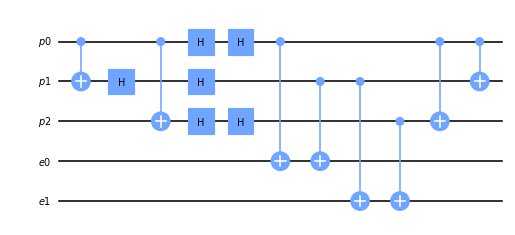

Starting execution...


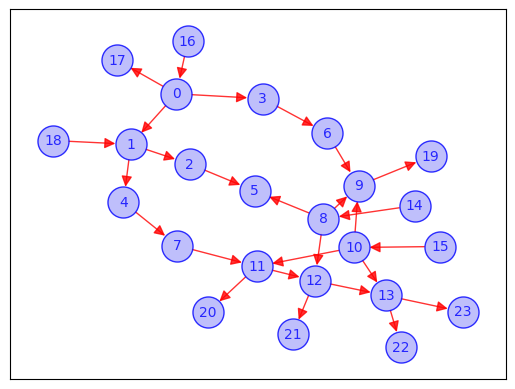

Initial circuit depth: 34
New circuit depth: 33
New circuit depth: 31
Most optimal score is: 31


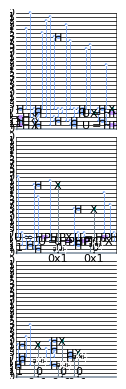

The execution has been completed. It took 33.20542025566101 seconds!


In [ ]:
import time
from networkx import Graph
from graphiq.circuit.ops import Hadamard, CNOT, Phase

engine: CircuitOptimizer = CircuitOptimizer(e=2, p=3, c=0)

engine.add(CNOT(control=0, control_type="p", target=1, target_type="p"))
engine.add(CNOT(control=0, control_type="p", target=2, target_type="p"))

#hadamards
engine.add(Hadamard(register=0, reg_type="p"))
engine.add(Hadamard(register=1, reg_type="p"))
engine.add(Hadamard(register=2, reg_type="p"))
# engine.add(SigmaZ(register=2, reg_type="p"))

# z gate error


#hadamards
engine.add(Hadamard(register=0, reg_type="p"))
engine.add(Hadamard(register=1, reg_type="p"))
engine.add(Hadamard(register=2, reg_type="p"))

#syndrome extraction
# engine.add(ClassicalCNOT(control=1, control_type="p", target=0, target_type="p", c_register=0))
engine.add(CNOT(control=0, control_type="p", target=0, target_type="e"))
engine.add(CNOT(control=1, control_type="p", target=0, target_type="e"))
engine.add(CNOT(control=1, control_type="p", target=1, target_type="e"))
engine.add(CNOT(control=2, control_type="p", target=1, target_type="e"))


engine.add(CNOT(control=0, control_type="p", target=2, target_type="p"))
engine.add(CNOT(control=0, control_type="p", target=1, target_type="p"))


engine.draw_circuit()
engine.get_graph_edges()
print("Starting execution...")
engine.plot_converted_numeric_graph()
start = time.time()
# engine.relabel_graph(engine.get_graph())
# engine.best_circuit_depth_of_isomorphic_graphs(100)
eq_lc_graphs: list[Graph] = engine.get_lc_equivalent_graphs(n)
engine.get_lowest_circuit_depth(eq_lc_graphs)
end = time.time()
length = end - start
print("The execution has been completed. It took", length, "seconds!")
#100+300+3000+30000+10000+1000


